## Name of file

### Imports

In [1]:
# basic data science libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt


# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV 

# models and validation
from sklearn import naive_bayes, svm
from sklearn import metrics

# load data from json file
import json
import re
import itertools
import emoji

# Text Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn


# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')

### Important variables

In [2]:
DATA_PATH = r"..\data"
SUBMISSIONS_PATH = r"..\submissions"
SAVE_SUBMISSION_MODE = True

### Load data

In [3]:
df_train = pd.read_csv(DATA_PATH + r"\train.csv")
df_test = pd.read_csv(DATA_PATH + r"\test.csv")
with open('en_contractions.json') as file:
    contractions = json.load(file)

## Preprocessing

In [4]:
def remove_contractions(text):
    """
    Function to replace contractions with their longer forms

    Args:
    string text: text to replace contractions

    Returns:
    string: replaced text
    """
    assert 'contractions' in globals(), "Json file with contractions not loaded"
    return contractions[text.lower()] if text.lower() in contractions.keys() else text

In [5]:
def clean_dataset(text):
    """
    Function to get rif off unwanted patterns
    Args:
    string text: text to clean

    Returns:
    string: replaced text
    """
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove whitespace (including new line characters)
    text = re.sub(r'\s\s+','', text)
    text = re.sub(r'[ ]{2, }',' ',text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 4 or fewer letters
    text = re.sub(r'\b\w{1,4}\b', '', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove misspelling words
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    # Remove emoji
    text = emoji.demojize(text)
    text = text.replace(":"," ")
    text = ' '.join(text.split()) 
    text = re.sub("([^\x00-\x7F])+"," ",text)
    # Remove Mojibake (also extra spaces)
    text = ' '.join(re.sub("[^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    return text

In [6]:
# Remove blank rows if any.
df_train['text'].dropna(inplace=True)
df_test['text'].dropna(inplace=True)

# Change all the text to lower case.
df_train['text'] = [entry.lower() for entry in df_train['text']]
df_test['text'] = [entry.lower() for entry in df_test['text']]

#Clean text
# df_train['text'] =df_train['text'].apply(clean_dataset)
# df_test['text'] =df_test['text'].apply(clean_dataset)

# Remove contractions
df_train['text']=df_train['text'].apply(remove_contractions)
df_test['text']=df_test['text'].apply(remove_contractions)

# Tokenization : In this each entry in the corpus will be broken into set of words
df_train['text']= [word_tokenize(entry) for entry in df_train['text']]
df_test['text']= [word_tokenize(entry) for entry in df_test['text']]

# Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Initializing WordNetLemmatizer()
word_Lemmatized = WordNetLemmatizer()

for index,entry in enumerate(df_train['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df_train.loc[index,'text_final'] = str(Final_words)

for index,entry in enumerate(df_test['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    df_test.loc[index,'text_final'] = str(Final_words)

In [7]:
df_train.head()

,id,keyword,location,text,target,text_final
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, #, ea...",1,"['deed', 'reason', 'earthquake', 'may', 'allah..."
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, ., canada]",1,"['forest', 'fire', 'near', 'la', 'ronge', 'sas..."
2,5,NaN,NaN,"[all, residents, asked, to, 'shelter, in, plac...",1,"['resident', 'ask', 'place', 'notify', 'office..."
3,6,NaN,NaN,"[13,000, people, receive, #, wildfires, evacua...",1,"['people', 'receive', 'wildfire', 'evacuation'..."
4,7,NaN,NaN,"[just, got, sent, this, photo, from, ruby, #, ...",1,"['get', 'send', 'photo', 'ruby', 'alaska', 'sm..."


In [8]:
# for submission whole dataset should be trained
X_train, X_test, y_train, y_test = train_test_split(df_train["text_final"],df_train["target"],test_size=.15)

In [9]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

Whole_Y = Encoder.fit_transform(df_train["target"])

In [10]:
# Convert a collection of raw documents to a matrix of TF-IDF features.
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df_train['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)
Whole_X_Tfidf = Tfidf_vect.transform(df_train['text_final'])

if SAVE_SUBMISSION_MODE:
    Test_X_Tfidf_subm = Tfidf_vect.transform(df_test['text_final'])


# Naive Bayes

In [11]:
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",metrics.accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  79.85989492119089


Model test:
		Prec: 0.8072916666666666         
		 Rec: 0.6652360515021459         
		 F1: 0.7294117647058824         
		 Acc: 0.7985989492119089


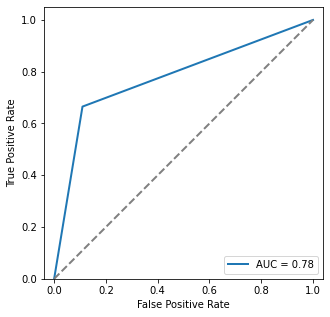

In [12]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_NB)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_NB)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_NB)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_NB)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_NB)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

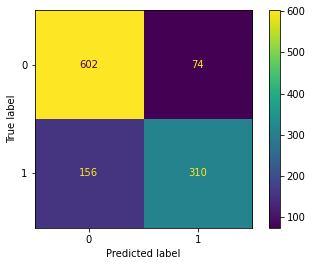

In [13]:
cm = metrics.confusion_matrix(Test_Y, predictions_NB, labels=Naive.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=Naive.classes_)
disp.plot()


In [14]:
predictions_NB_custom_threshold = Naive.predict_proba(Test_X_Tfidf)
y_pred = (predictions_NB_custom_threshold[:,1] >= .45).astype(bool).astype(int) 
metrics.f1_score(y_pred, Test_Y)*100

73.71937639198218

In [15]:
if SAVE_SUBMISSION_MODE:
    Naive = naive_bayes.MultinomialNB()
    Naive.fit(Whole_X_Tfidf,Whole_Y)
    submission_NB = Naive.predict(Test_X_Tfidf_subm)
    submission_NB = pd.DataFrame(submission_NB)
    tmp = pd.concat([df_test,submission_NB], axis = 1 )


    # submission_NB_custom_threshold = Naive.predict_proba(Test_X_Tfidf_subm)
    # submission_NB_custom_threshold = (submission_NB_custom_threshold[:,1] >= .45)
    # submission_NB_custom_threshold = pd.DataFrame(submission_NB_custom_threshold)
    # tmp = pd.concat([df_test,submission_NB_custom_threshold], axis = 1 )
    
    
    tmp = tmp.drop(["text","keyword","location","text_final"], axis = 1)
    tmp.columns = ['id', "target"]
    tmp.to_csv(SUBMISSIONS_PATH + r"\submissionNB.csv", index = False)


In [16]:
predictions_NB_custom_threshold.shape

(1142, 2)

In [17]:
len(predictions_NB_custom_threshold[:,0])

1142

# SVM

In [18]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC()
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",metrics.accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  79.42206654991243


Model test:
		Prec: 0.8147138964577657         
		 Rec: 0.6416309012875536         
		 F1: 0.7178871548619449         
		 Acc: 0.7942206654991243         
		 ROC_AUC: 0.7705195926556112


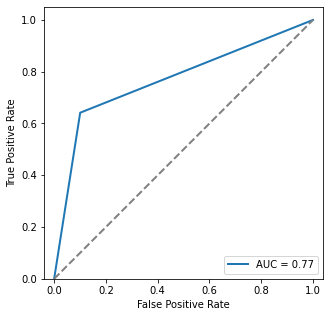

In [19]:
print('Model test:')

print(f'\t\tPrec: {metrics.precision_score(Test_Y, predictions_SVM)} \
        \n\t\t Rec: {metrics.recall_score(Test_Y, predictions_SVM)} \
        \n\t\t F1: {metrics.f1_score(Test_Y, predictions_SVM)} \
        \n\t\t Acc: {metrics.accuracy_score(Test_Y, predictions_SVM)} \
        \n\t\t ROC_AUC: {metrics.roc_auc_score(Test_Y, predictions_SVM)}')

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, predictions_SVM)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.axis('equal')
plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

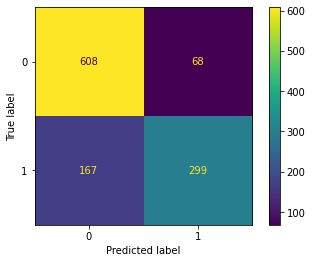

In [20]:
cm = metrics.confusion_matrix(Test_Y, predictions_SVM, labels=SVM.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=SVM.classes_)
disp.plot()



## Grid Search

In [21]:
# defining parameter range
param_grid = {'C': [.7, .8, .9, 1 ,1.1, 1.2],
              'gamma': [.5, 1, 1.5],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVM, param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(Train_X_Tfidf,Train_Y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ......C=0.7, gamma=0.5, kernel=rbf;, score=0.798 total time=   2.9s
[CV 2/5] END ......C=0.7, gamma=0.5, kernel=rbf;, score=0.806 total time=   3.0s
[CV 3/5] END ......C=0.7, gamma=0.5, kernel=rbf;, score=0.804 total time=   2.8s
[CV 4/5] END ......C=0.7, gamma=0.5, kernel=rbf;, score=0.774 total time=   2.7s
[CV 5/5] END ......C=0.7, gamma=0.5, kernel=rbf;, score=0.802 total time=   2.8s
[CV 1/5] END ........C=0.7, gamma=1, kernel=rbf;, score=0.798 total time=   3.0s
[CV 2/5] END ........C=0.7, gamma=1, kernel=rbf;, score=0.794 total time=   3.1s
[CV 3/5] END ........C=0.7, gamma=1, kernel=rbf;, score=0.801 total time=   3.0s
[CV 4/5] END ........C=0.7, gamma=1, kernel=rbf;, score=0.772 total time=   3.1s
[CV 5/5] END ........C=0.7, gamma=1, kernel=rbf;, score=0.799 total time=   3.3s
[CV 1/5] END ......C=0.7, gamma=1.5, kernel=rbf;, score=0.779 total time=   3.4s
[CV 2/5] END ......C=0.7, gamma=1.5, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.7, 0.8, 0.9, 1, 1.1, 1.2],
                         'gamma': [0.5, 1, 1.5], 'kernel': ['rbf']},
             verbose=3)

In [22]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1.2, 'gamma': 0.5, 'kernel': 'rbf'}
SVC(C=1.2, gamma=0.5)


In [23]:
from sklearn.metrics import classification_report


grid_predictions = grid.predict(Test_X_Tfidf)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       676
           1       0.81      0.64      0.72       466

    accuracy                           0.79      1142
   macro avg       0.80      0.77      0.78      1142
weighted avg       0.80      0.79      0.79      1142



In [24]:
if SAVE_SUBMISSION_MODE:
    

    Test_X_Tfidf_subm = Tfidf_vect.transform(df_test['text_final'])

    submission_SVM = grid.predict(Test_X_Tfidf_subm)
    submission_SVM = pd.DataFrame(submission_SVM)
    tmp = pd.concat([df_test,submission_SVM], axis = 1 )
    tmp = tmp.drop(["text","keyword","location","text_final"], axis = 1)
    tmp.columns = ['id', "target"]
    tmp.to_csv(SUBMISSIONS_PATH + r"\submissionGridSVM.csv", index = False)
